### Import libraries

In [1]:
from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Deactive warnings about building from source

from scipy.misc import imread, imresize
from datetime import datetime
from os.path import exists
from shutil import rmtree
from os import makedirs
import tensorflow as tf
from glob import glob
import numpy as np

from models import two_layer_convnet
from pymvtest import classification

import matplotlib.pyplot as plt
%matplotlib inline

### Define a master dictionary

In [8]:
TF = {
      'batch_size':32,
      'graph':None,
      'image_size':200, # Resize full images to this size
      'patch_size':20,  # We'll be changing these later
      'input_channels':1,
      'learning_rate':0.001,
      'n_classes':2,
      'output_channels':[16, 8, 32],
      'filter_size':[3, 5],
      'seed':3,
      'split_fraction':0.7,
      'summary_train':[],
      'training_steps':101,
      'test_id':'pending',
}
print('Training for {} iterations.'.format(TF['training_steps']))
print('{} units per batch.'.format(TF['batch_size']))

Training for 101 iterations.
32 units per batch.


### Import the data

In [9]:
print('Importing data...')

# Whiten on import
images = np.array([np.expand_dims((imread(fp).astype(np.float32) - 128)/255, axis = -1)
                  for fp in glob('./data/resized-images/*.png')])
masks  = np.array([imread(fp)/255 for fp in glob('./data/masked-images/*.png')])

# Resize to 200 x 200
images, masks = classification.resize(images, masks, TF['image_size'])

# Extract three images for testing, use the test for training/validation
query_ix      = np.array([(i == 9 or i == 14 or i ==24) for i in range(0, images.shape[0])])
train_ix      = np.logical_not(query_ix)
query_images  = images[query_ix, :, :, :]
query_masks   = masks[query_ix, :, :]
images        = images[train_ix, :, :, :]
masks         = masks[train_ix, :, :]

print('Data imported and resized.')

Importing data...
Data imported and resized.


### Fit the model at each patch + image size, then save the test predictions as images

Training dataset dimensions: (37, 200, 200, 1)
Validation dataset dimensions: (12, 200, 200, 1)

Fitting model...
(Step   0  ) Validation accuracy:    0.44

(Step  100 ) Minibatch accuracy:     0.47
(Step  100 ) Minibatch loss:       0.6928
(Step  100 ) Validation accuracy:    0.54

INFO:tensorflow:Restoring parameters from ./checkpoints/001_Patch_and_image_size_image_50patch_5.ckpt


ValueError: Tensor("Inputs/BatchImages:0", shape=(), dtype=string) must be from the same graph as Tensor("Inputs/BatchImages:0", shape=(), dtype=string).

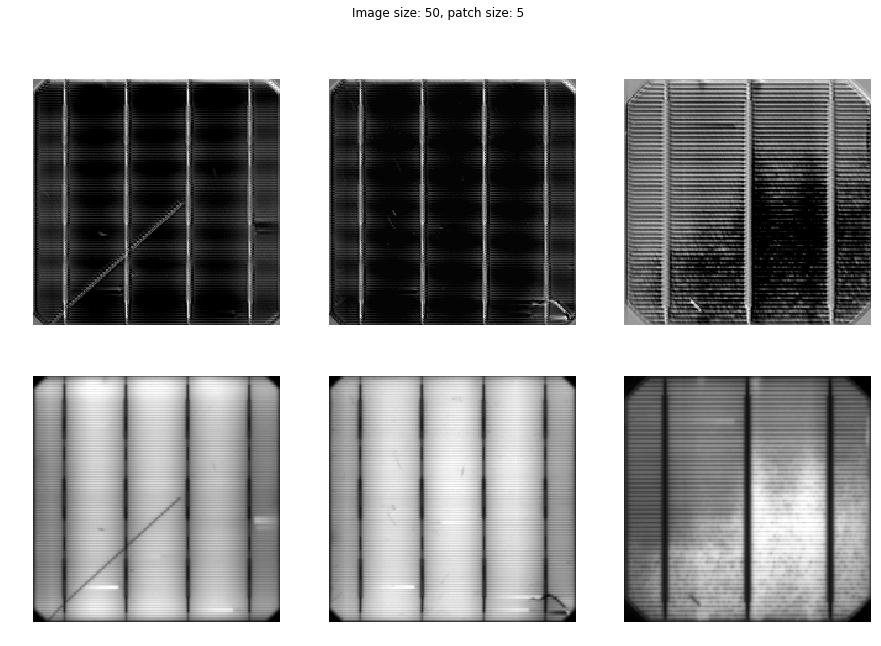

In [10]:
if exists('./results/001_Patch_and_image_size'): rmtree('./results/001_Patch_and_image_size')
makedirs('./results/001_Patch_and_image_size')

patch_sizes = [5, 10, 15, 20, 40]
image_sizes = [50, 100, 150, 200, 400]

for patch_size in patch_sizes:
    for image_size in image_sizes:
        # Update the dictionary
        TF['summary_train'] = [] # We append to this in the graph
        TF['image_size']    = image_size
        TF['patch_size']    = patch_size
        TF['test_id']       = '001_Patch_and_image_size_image_'+str(image_size)+'_patch_'+str(patch_size) 
        
        # Update the graph
        TF     = two_layer_convnet.model(TF)
        
        # Fit the model
        tester = classification.Tester(images, masks, TF)
        tester.fit_model()
        
        # Query the model
        predictions, masks = tester.query_model(query_images, query_masks)
        
        # Plot and save the predictions
        f, axs = plt.subplots(2, 3, figsize = (15, 10))
        for i, ax in enumerate(axs.flatten()):
            if i < 3:
                ax.imshow(predictions[i, :, :], cmap = 'gray')
                ax.axis('off')
            else:
                ax.imshow(query_images[np.floor(i-3).astype(int), :, :, 0], cmap = 'gray')
                ax.axis('off')
        f.suptitle('Image size: {}, patch size: {}'.format(TF['image_size'], TF['patch_size']))
        f.savefig('./results/001_Patch_and_image_size/image_{}_patch_{}.png'.format(TF['image_size'],
                                                                                    TF['patch_size']), dpi = 400)

### Present the images